# Uncertainty Quantification for Regression with MAPIE

In [15]:
import sys
sys.path.append("..")

from pathlib import Path
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score, train_test_split

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

from lib.get_config import get_config
cfg = get_config('../config/config.yaml')

Load config file >> ../config/config.yaml


In [2]:
y_rescaled = lambda y_label: yscaler.inverse_transform(np.asarray(y_label)[...,np.newaxis]).flatten()
df = pd.read_csv(Path(cfg['data_dir'], 'catalogue', 'sdssdr16q_prop.csv'), sep=',', header=0)

## Define functions

In [3]:
def eval_prederror(estimator, X_test, y_test, y_pred, cv=10):
    """Evaluate prediction error"""
    
    mae = np.abs(y_test - y_pred).mean()
    mae_cv = np.abs(cross_val_score(estimator, X=X_test, y=y_test, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1))
    rmse = np.sqrt(((y_test - y_pred)**2).mean())
    rmse_cv = np.sqrt(np.abs(cross_val_score(estimator, X=X_test, y=y_test, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)))
    
    return {'mae': mae, 'mae_mean': np.mean(mae_cv), 'mae_stddev': np.std(mae_cv),
            'rmse': rmse, 'rmse_mean': np.mean(rmse_cv), 'rmse_stddev': np.std(rmse_cv)}


In [4]:
def plot_predvstargetuq(target, pred, lower, upper, metrics=None, tstd=None, ax=None, onetoone_refloc=0, xlabel=None, ylabel=None, plot_legend=True, save_plot=False):
    """Plot prediction against target"""
    
    iline_kwargs = {'ls': '--', 'color': 'gray', 'alpha': 0.6}
    color = iter(plt.get_cmap('tab10').colors)
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(5,5))
    # Conformal prediction
    ax.plot(target, pred, linestyle=':', lw=1, alpha=0.8, zorder=5, label='prediction')
    ax.fill_between(target, lower, upper, color=next(color), edgecolor='none', alpha=0.3, zorder=5)
    xlim, ylim = ax.get_xlim(), ax.get_ylim()
    min_lim, max_lim = np.min((xlim, ylim)), np.max((xlim, ylim))
    # Target within standard deviation
    if isinstance(tstd, (int, float)):
        targetstd = np.linspace(min_lim, max_lim, 10)
        ax.fill_between(targetstd, targetstd-tstd, targetstd+tstd, color=next(color), edgecolor='none', alpha=0.15, label=f"stddev={tstd}")
    # Metrics
    if isinstance(metrics, dict):
        yoffset = 0.
        for k, v in metrics.items():
            ax.annotate(f"{k}={v:.3f}", xy=(0.05, 0.95+yoffset), xycoords='axes fraction')
            yoffset -= 0.05
    
    ax.axline([onetoone_refloc, onetoone_refloc], slope=1, **iline_kwargs)
    ax.set_xlim(min_lim, max_lim)
    ax.set_ylim(min_lim, max_lim)
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlabel('Target' if xlabel is None else xlabel)
    ax.set_ylabel('Prediction' if ylabel is None else ylabel)
    if plot_legend: ax.legend(loc='lower right')
    if save_plot: fig.savefig('plots/predvstargetuq.pdf', bbox_inches='tight')
    # plt.show()


def plot_allpredvstargetuq(uq_dict, tstd=0.5, xlabel=None, ylabel=None, save_plot=False):
    """Plot prediction against target for all uncertainty quantification methods"""
    fig, axes = plt.subplots(2, 3, figsize=(10, 7.5), sharex=True, sharey=True, gridspec_kw={'hspace': 0., 'wspace': 0.})
    nstrategy = len(uq_dict.keys())
    for i, (ax, s) in enumerate(zip(axes.flatten(), uq_dict.keys())):
        plot_predvstargetuq(uq_dict[s]['target'], uq_dict[s]['pred'], uq_dict[s]['lower'], uq_dict[s]['upper'], metrics=uq_dict[s]['pierr_metric'],
                            tstd=tstd, ax=ax, onetoone_refloc=8, xlabel='', ylabel='',
                            plot_legend=True if i==(nstrategy-1) else False, save_plot=False)
        if i >= nstrategy-3:
            ax.set_xlabel(xlabel)
        if (i % 3) == 0:
            ax.set_ylabel(ylabel)
        ax.set_title(s, fontsize=10)
    if save_plot: fig.savefig('plots/allpredvstargetuq.pdf', bbox_inches='tight')
    plt.show()


def plot_coveragewidthvsalpha(df_coverage, df_width, save_plot=False):
    """Plot coverage and mean width scores against 1-alpha"""
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw={'wspace': 0.2})
    for strategy in df_coverage.columns:
        r2scorepercent = 100.*r2_score(1-df_coverage.index, df_coverage[strategy], force_finite=False)
        axes[0].plot(1-df_coverage.index.to_numpy(), df_coverage[strategy], '.-', markersize=10, lw=1, alpha=0.8, label=rf"$R^{2}_\mathrm{{{strategy.replace('_', ' ')}}}={r2scorepercent:.2f}$%")
        axes[1].plot(1-df_width.index.to_numpy(), df_width[strategy], '.-', markersize=10, lw=1, alpha=0.8, label=strategy)
    for ax in axes:
        ax.set_xlim(0, 1)
        ax.set_xlabel(r"$1-\alpha$")
        ax.legend(handlelength=1.5, labelspacing=0.2)
    axes[0].axline([1, 1], slope=1, ls='--', color='gray', alpha=0.6)
    axes[0].set_ylim(0, 1)
    axes[1].set_ylim(0, None)
    axes[0].set_ylabel("Coverage Score")
    axes[1].set_ylabel("Mean Width")
    plt.show()
    if save_plot: fig.savefig('plots/coveragewidthvsalpha.pdf', bbox_inches='tight')


## For Hb virial BH mass

### Load output files

In [16]:
# Features
logdir_exp = Path(cfg['data_dir'], 'logs', '20230309/150244_LOGMBH_HB')

datasplit_idx = pd.read_pickle(Path(logdir_exp, 'datasplitidx.pkl'))
datasplit_idx['valid'], datasplit_idx['test'] = train_test_split(datasplit_idx['test'], test_size=cfg['frac_test_size'], random_state=cfg['seed'])
df_features = pd.read_pickle(Path(logdir_exp, 'features.pkl'))
yscaler = pd.read_pickle(Path(logdir_exp, 'yscaler.pkl'))

feature_keys = [k for k in df_features.columns if isinstance(k, int)]
dffeatures_train = df_features.loc[datasplit_idx['train']]
dffeatures_valid = df_features.loc[datasplit_idx['valid']]
dffeatures_test = df_features.loc[datasplit_idx['test']]

In [17]:
# Regressors
estimator = pd.read_pickle(Path(logdir_exp, 'estimator_optim.pkl'))
print(f"Best estimator >> {estimator}")
estimator_q = pd.read_pickle(Path(logdir_exp, 'estimatorq_optim.pkl'))
print(f"Best estimator >> {estimator_q}")
y_pred, y_pis, uq_dict = pd.read_pickle(Path(logdir_exp, 'mapieuq_pred.pkl'))
df_coverage = pd.read_pickle(Path(logdir_exp, 'mapieuq_coverage_alpha.pkl'))
df_width = pd.read_pickle(Path(logdir_exp, 'mapieuq_width_alpha.pkl'))

Best estimator >> RandomForestRegressor(max_depth=5, n_estimators=319, random_state=42)
Best estimator >> GradientBoostingRegressor(alpha=0.5, learning_rate=0.013264961159866528,
                          loss='quantile', max_depth=26, max_leaf_nodes=15,
                          n_estimators=251, random_state=42)


### Prediction results

In [18]:
# Evaluate prediction error
pd.DataFrame(
    {str(estimator).rpartition('(')[0]: eval_prederror(estimator, dffeatures_test[feature_keys].to_numpy(), dffeatures_test['label'].to_numpy(), y_pred['cv_plus'], cv=10)} | \
    {str(estimator_q).rpartition('(')[0]: eval_prederror(estimator_q, dffeatures_test[feature_keys].to_numpy(), dffeatures_test['label'].to_numpy(), y_pred['cqr'], cv=10)}
).style.format('{:.3f}')


,RandomForestRegressor,GradientBoostingRegressor
mae,0.105,0.105
mae_mean,0.105,0.109
mae_stddev,0.010,0.010
rmse,0.140,0.141
rmse_mean,0.136,0.140
rmse_stddev,0.012,0.012


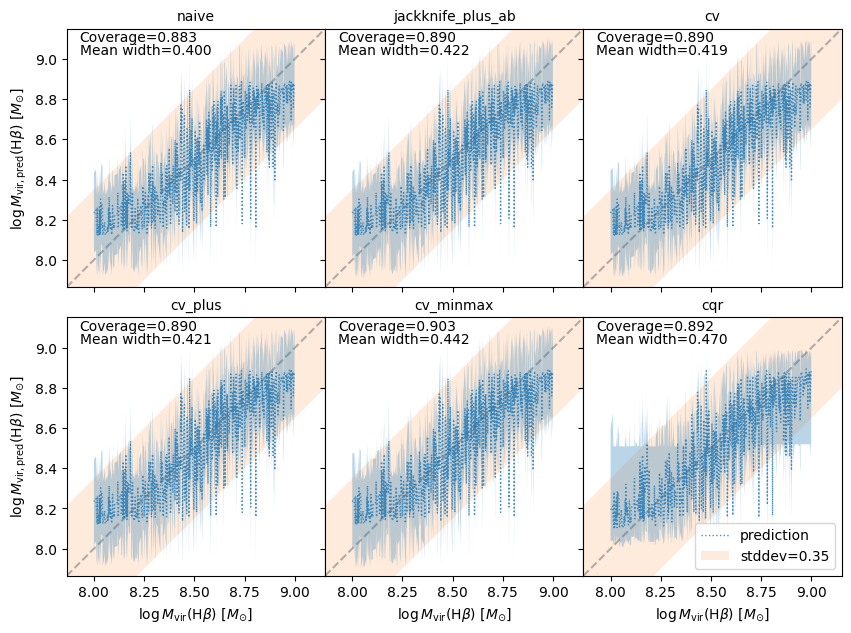

In [19]:
# For single method
# s = 'cqr'
# plot_predvstargetuq(uq_dict[s]['target'], uq_dict[s]['pred'], uq_dict[s]['lower'], uq_dict[s]['upper'], metrics=uq_dict[s]['pierr_metric'], tstd=0.5, ax=None, onetoone_refloc=8,
#                     xlabel=r'$\log M_{\mathrm{vir}}(\mathrm{H}\beta)\ [M_{\odot}]$', ylabel=r'$\log M_{\mathrm{vir,pred}}(\mathrm{H}\beta)\ [M_{\odot}]$',
#                     save_plot=False)

# For all
plot_allpredvstargetuq(uq_dict, tstd=0.35,
                        xlabel=r'$\log M_{\mathrm{vir}}(\mathrm{H}\beta)\ [M_{\odot}]$', ylabel=r'$\log M_{\mathrm{vir,pred}}(\mathrm{H}\beta)\ [M_{\odot}]$',
                        save_plot=True)

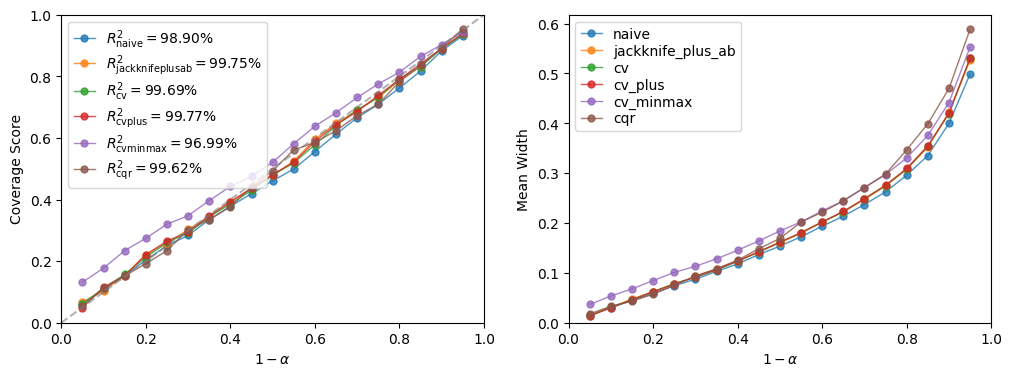

In [20]:
plot_coveragewidthvsalpha(df_coverage, df_width, save_plot=True)

## For MgII virial BH mass

### Load output files

In [21]:
# Features
logdir_exp = Path(cfg['data_dir'], 'logs', '20230309/163305_LOGMBH_MGII')

datasplit_idx = pd.read_pickle(Path(logdir_exp, 'datasplitidx.pkl'))
datasplit_idx['valid'], datasplit_idx['test'] = train_test_split(datasplit_idx['test'], test_size=cfg['frac_test_size'], random_state=cfg['seed'])
df_features = pd.read_pickle(Path(logdir_exp, 'features.pkl'))
yscaler = pd.read_pickle(Path(logdir_exp, 'yscaler.pkl'))

feature_keys = [k for k in df_features.columns if isinstance(k, int)]
dffeatures_train = df_features.loc[datasplit_idx['train']]
dffeatures_valid = df_features.loc[datasplit_idx['valid']]
dffeatures_test = df_features.loc[datasplit_idx['test']]

In [22]:
# Regressors
estimator = pd.read_pickle(Path(logdir_exp, 'estimator_optim.pkl'))
print(f"Best estimator >> {estimator}")
estimator_q = pd.read_pickle(Path(logdir_exp, 'estimatorq_optim.pkl'))
print(f"Best estimator >> {estimator_q}")
y_pred, y_pis, uq_dict = pd.read_pickle(Path(logdir_exp, 'mapieuq_pred.pkl'))
df_coverage = pd.read_pickle(Path(logdir_exp, 'mapieuq_coverage_alpha.pkl'))
df_width = pd.read_pickle(Path(logdir_exp, 'mapieuq_width_alpha.pkl'))

Best estimator >> RandomForestRegressor(max_depth=5, n_estimators=231, random_state=42)
Best estimator >> GradientBoostingRegressor(alpha=0.5, learning_rate=0.013264961159866528,
                          loss='quantile', max_depth=26, max_leaf_nodes=15,
                          n_estimators=251, random_state=42)


### Prediction results

In [23]:
# Evaluate prediction error
pd.DataFrame(
    {str(estimator).rpartition('(')[0]: eval_prederror(estimator, dffeatures_test[feature_keys].to_numpy(), dffeatures_test['label'].to_numpy(), y_pred['cv_plus'], cv=10)} | \
    {str(estimator_q).rpartition('(')[0]: eval_prederror(estimator_q, dffeatures_test[feature_keys].to_numpy(), dffeatures_test['label'].to_numpy(), y_pred['cqr'], cv=10)}
).style.format('{:.3f}')


,RandomForestRegressor,GradientBoostingRegressor
mae,0.120,0.121
mae_mean,0.125,0.128
mae_stddev,0.013,0.014
rmse,0.155,0.157
rmse_mean,0.161,0.164
rmse_stddev,0.012,0.012


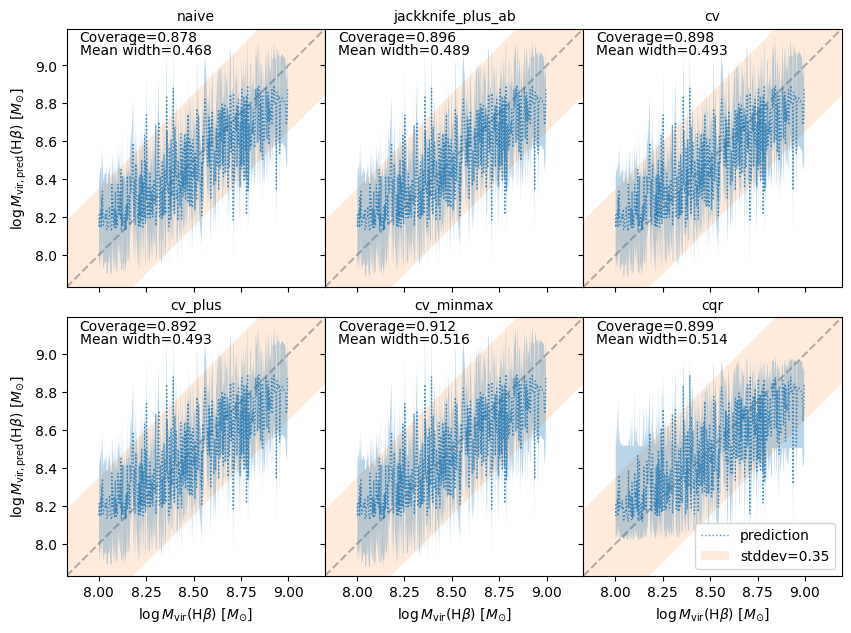

In [24]:
# For single method
# s = 'cqr'
# plot_predvstargetuq(uq_dict[s]['target'], uq_dict[s]['pred'], uq_dict[s]['lower'], uq_dict[s]['upper'], metrics=uq_dict[s]['pierr_metric'], tstd=0.5, ax=None, onetoone_refloc=8,
#                     xlabel=r'$\log M_{\mathrm{vir}}(\mathrm{H}\beta)\ [M_{\odot}]$', ylabel=r'$\log M_{\mathrm{vir,pred}}(\mathrm{H}\beta)\ [M_{\odot}]$',
#                     save_plot=False)

# For all
plot_allpredvstargetuq(uq_dict, tstd=0.35,
                        xlabel=r'$\log M_{\mathrm{vir}}(\mathrm{H}\beta)\ [M_{\odot}]$', ylabel=r'$\log M_{\mathrm{vir,pred}}(\mathrm{H}\beta)\ [M_{\odot}]$',
                        save_plot=True)

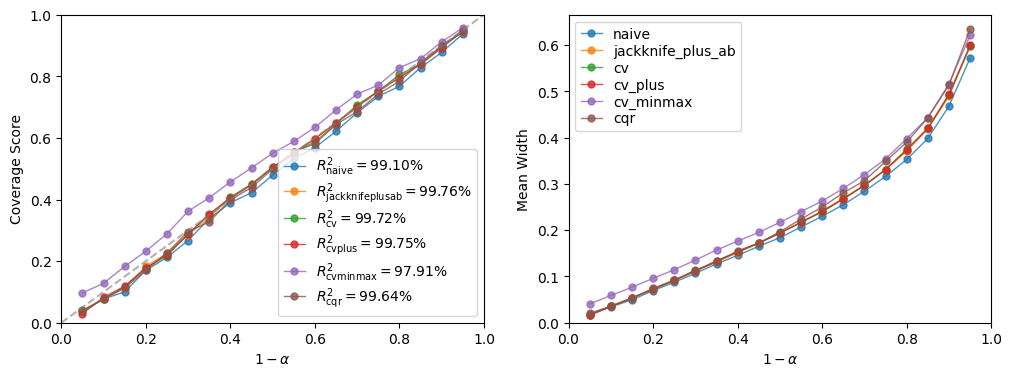

In [25]:
plot_coveragewidthvsalpha(df_coverage, df_width, save_plot=True)

## All Data - For Hb virial BH mass

### Load output files

In [5]:
# Features
logdir_exp = Path(cfg['data_dir'], 'logs', '20230310/184508_LOGMBH_HB')

datasplit_idx = pd.read_pickle(Path(logdir_exp, 'datasplitidx.pkl'))
datasplit_idx['valid'], datasplit_idx['test'] = train_test_split(datasplit_idx['test'], test_size=cfg['frac_test_size'], random_state=cfg['seed'])
df_features = pd.read_pickle(Path(logdir_exp, 'features.pkl'))
yscaler = pd.read_pickle(Path(logdir_exp, 'yscaler.pkl'))

feature_keys = [k for k in df_features.columns if isinstance(k, int)]
dffeatures_train = df_features.loc[datasplit_idx['train']]
dffeatures_valid = df_features.loc[datasplit_idx['valid']]
dffeatures_test = df_features.loc[datasplit_idx['test']]

In [6]:
# Regressors
estimator = pd.read_pickle(Path(logdir_exp, 'estimator_optim.pkl'))
print(f"Best estimator >> {estimator}")
estimator_q = pd.read_pickle(Path(logdir_exp, 'estimatorq_optim.pkl'))
print(f"Best estimator >> {estimator_q}")
y_pred, y_pis, uq_dict = pd.read_pickle(Path(logdir_exp, 'mapieuq_pred.pkl'))
df_coverage = pd.read_pickle(Path(logdir_exp, 'mapieuq_coverage_alpha.pkl'))
df_width = pd.read_pickle(Path(logdir_exp, 'mapieuq_width_alpha.pkl'))

Best estimator >> RandomForestRegressor(max_depth=8, n_estimators=445, random_state=42)
Best estimator >> GradientBoostingRegressor(alpha=0.5, learning_rate=0.050768531039396936,
                          loss='quantile', max_depth=20, max_leaf_nodes=24,
                          n_estimators=152, random_state=42)


### Prediction results

In [7]:
# Evaluate prediction error
pd.DataFrame(
    {str(estimator).rpartition('(')[0]: eval_prederror(estimator, dffeatures_test[feature_keys].to_numpy(), dffeatures_test['label'].to_numpy(), y_pred['cv_plus'], cv=10)} | \
    {str(estimator_q).rpartition('(')[0]: eval_prederror(estimator_q, dffeatures_test[feature_keys].to_numpy(), dffeatures_test['label'].to_numpy(), y_pred['cqr'], cv=10)}
).style.format('{:.3f}')


,RandomForestRegressor,GradientBoostingRegressor
mae,0.124,0.124
mae_mean,0.134,0.132
mae_stddev,0.015,0.011
rmse,0.171,0.171
rmse_mean,0.182,0.178
rmse_stddev,0.024,0.022


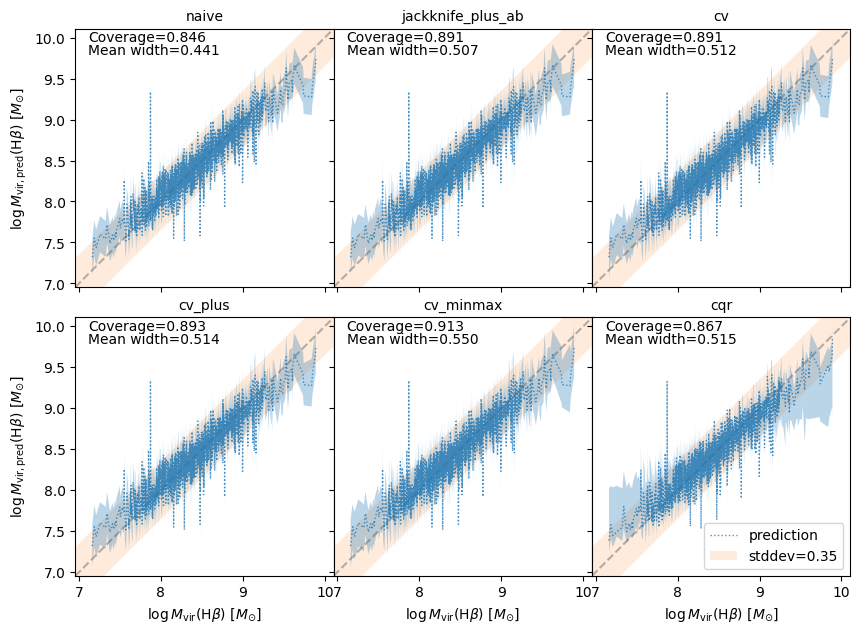

In [8]:
# For single method
# s = 'cqr'
# plot_predvstargetuq(uq_dict[s]['target'], uq_dict[s]['pred'], uq_dict[s]['lower'], uq_dict[s]['upper'], metrics=uq_dict[s]['pierr_metric'], tstd=0.5, ax=None, onetoone_refloc=8,
#                     xlabel=r'$\log M_{\mathrm{vir}}(\mathrm{H}\beta)\ [M_{\odot}]$', ylabel=r'$\log M_{\mathrm{vir,pred}}(\mathrm{H}\beta)\ [M_{\odot}]$',
#                     save_plot=False)

# For all
plot_allpredvstargetuq(uq_dict, tstd=0.35,
                        xlabel=r'$\log M_{\mathrm{vir}}(\mathrm{H}\beta)\ [M_{\odot}]$', ylabel=r'$\log M_{\mathrm{vir,pred}}(\mathrm{H}\beta)\ [M_{\odot}]$',
                        save_plot=True)

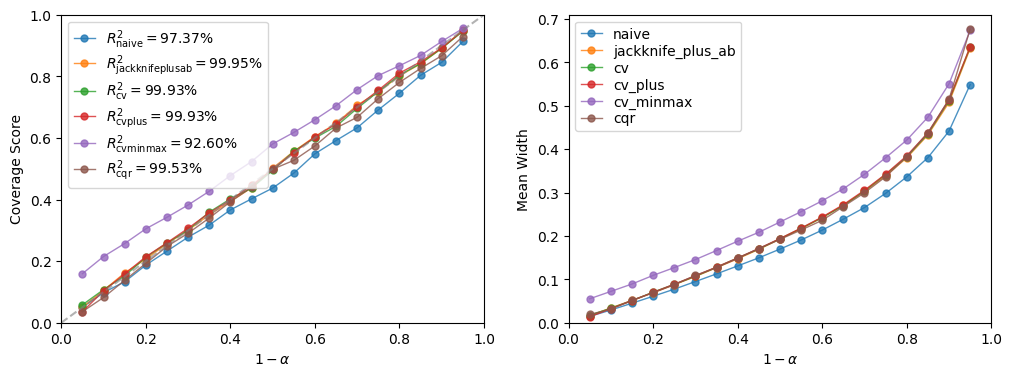

In [9]:
plot_coveragewidthvsalpha(df_coverage, df_width, save_plot=True)

## All Data - For MgII virial BH mass

### Load output files

In [10]:
# Features
logdir_exp = Path(cfg['data_dir'], 'logs', '20230311/010755_LOGMBH_MGII')

datasplit_idx = pd.read_pickle(Path(logdir_exp, 'datasplitidx.pkl'))
datasplit_idx['valid'], datasplit_idx['test'] = train_test_split(datasplit_idx['test'], test_size=cfg['frac_test_size'], random_state=cfg['seed'])
df_features = pd.read_pickle(Path(logdir_exp, 'features.pkl'))
yscaler = pd.read_pickle(Path(logdir_exp, 'yscaler.pkl'))

feature_keys = [k for k in df_features.columns if isinstance(k, int)]
dffeatures_train = df_features.loc[datasplit_idx['train']]
dffeatures_valid = df_features.loc[datasplit_idx['valid']]
dffeatures_test = df_features.loc[datasplit_idx['test']]

In [11]:
# Regressors
estimator = pd.read_pickle(Path(logdir_exp, 'estimator_optim.pkl'))
print(f"Best estimator >> {estimator}")
estimator_q = pd.read_pickle(Path(logdir_exp, 'estimatorq_optim.pkl'))
print(f"Best estimator >> {estimator_q}")
y_pred, y_pis, uq_dict = pd.read_pickle(Path(logdir_exp, 'mapieuq_pred.pkl'))
df_coverage = pd.read_pickle(Path(logdir_exp, 'mapieuq_coverage_alpha.pkl'))
df_width = pd.read_pickle(Path(logdir_exp, 'mapieuq_width_alpha.pkl'))

Best estimator >> RandomForestRegressor(max_depth=7, n_estimators=395, random_state=42)
Best estimator >> GradientBoostingRegressor(alpha=0.5, learning_rate=0.050768531039396936,
                          loss='quantile', max_depth=20, max_leaf_nodes=24,
                          n_estimators=152, random_state=42)


### Prediction results

In [12]:
# Evaluate prediction error
pd.DataFrame(
    {str(estimator).rpartition('(')[0]: eval_prederror(estimator, dffeatures_test[feature_keys].to_numpy(), dffeatures_test['label'].to_numpy(), y_pred['cv_plus'], cv=10)} | \
    {str(estimator_q).rpartition('(')[0]: eval_prederror(estimator_q, dffeatures_test[feature_keys].to_numpy(), dffeatures_test['label'].to_numpy(), y_pred['cqr'], cv=10)}
).style.format('{:.3f}')


,RandomForestRegressor,GradientBoostingRegressor
mae,0.153,0.151
mae_mean,0.159,0.160
mae_stddev,0.005,0.006
rmse,0.204,0.203
rmse_mean,0.211,0.210
rmse_stddev,0.009,0.009


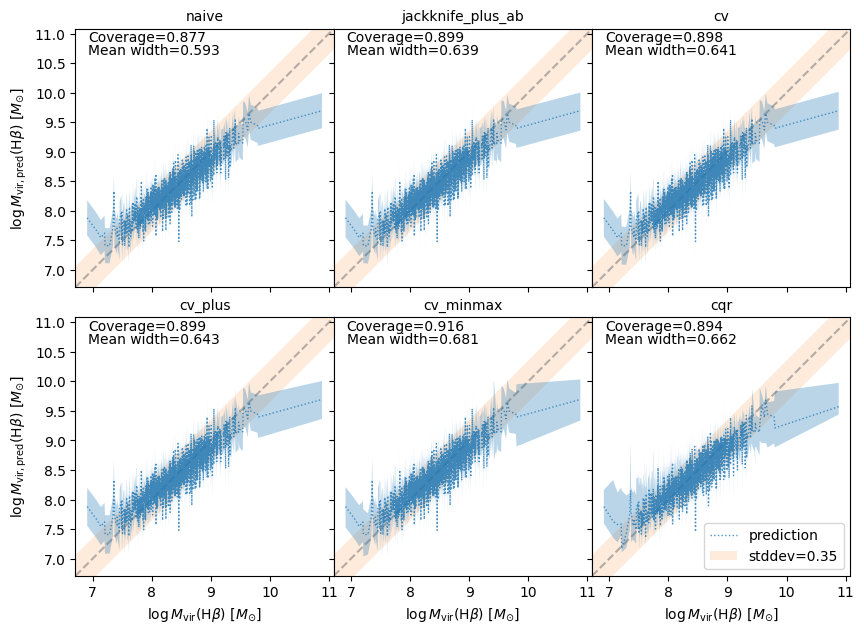

In [13]:
# For single method
# s = 'cqr'
# plot_predvstargetuq(uq_dict[s]['target'], uq_dict[s]['pred'], uq_dict[s]['lower'], uq_dict[s]['upper'], metrics=uq_dict[s]['pierr_metric'], tstd=0.5, ax=None, onetoone_refloc=8,
#                     xlabel=r'$\log M_{\mathrm{vir}}(\mathrm{H}\beta)\ [M_{\odot}]$', ylabel=r'$\log M_{\mathrm{vir,pred}}(\mathrm{H}\beta)\ [M_{\odot}]$',
#                     save_plot=False)

# For all
plot_allpredvstargetuq(uq_dict, tstd=0.35,
                        xlabel=r'$\log M_{\mathrm{vir}}(\mathrm{H}\beta)\ [M_{\odot}]$', ylabel=r'$\log M_{\mathrm{vir,pred}}(\mathrm{H}\beta)\ [M_{\odot}]$',
                        save_plot=True)

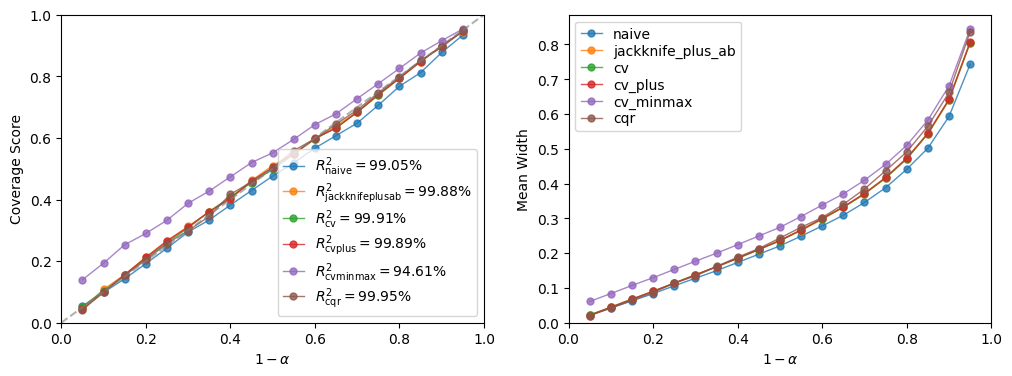

In [14]:
plot_coveragewidthvsalpha(df_coverage, df_width, save_plot=True)